In [1]:
from pathlib import Path
import os
import sys

main_directory = Path(os.path.abspath("")).parent
sys.path.append(str(main_directory))

## Create a JSSP problem instance

In [2]:
from queasars.job_shop_scheduling.problem_instances import Machine, Operation, Job, JobShopSchedulingProblemInstance

machines = (Machine(name="m0"), Machine(name="m1"))

j0op1 = Operation(name="j0op0", machine=machines[0], processing_duration=2, job_name="j0")
j0op2 = Operation(name="j0op1", machine=machines[1], processing_duration=1, job_name="j0")
job0 = Job(name="j0", operations=(j0op1, j0op2))

j1op1 = Operation(name="j1op1", machine=machines[0], processing_duration=1, job_name="j1")
j1op2 = Operation(name="j1op2", machine=machines[1], processing_duration=2, job_name="j1")
job1 = Job(name="j1", operations=(j1op1, j1op2))

jssp_instance = JobShopSchedulingProblemInstance(name="Simple Instance", machines=machines, jobs=(job0, job1))

## Visualize the created problem instance (optional)

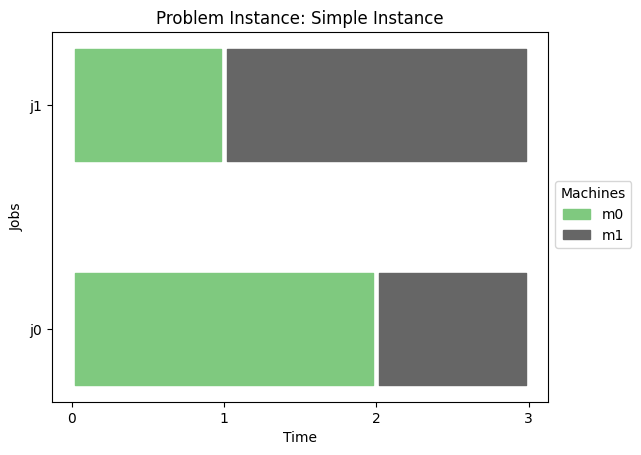

In [3]:
from queasars.job_shop_scheduling.visualization import plot_jssp_problem_instance_gantt

plot = plot_jssp_problem_instance_gantt(problem_instance=jssp_instance)

## Convert the problem instance to a hamiltonian

In [4]:
from queasars.job_shop_scheduling.domain_wall_hamiltonian_encoder import JSSPDomainWallHamiltonianEncoder

encoder = JSSPDomainWallHamiltonianEncoder(jssp_instance=jssp_instance, makespan_limit=5)

print("needed qubits: ", encoder.n_qubits)

hamiltonian = encoder.get_problem_hamiltonian()

needed qubits:  8


In [5]:
from qiskit import QuantumCircuit
from qiskit.primitives import SamplerResult
from qiskit.primitives.base import BaseSamplerV1
from qiskit.primitives.primitive_job import PrimitiveJob
from qiskit.transpiler import PassManager

# Sampler Primitive Wrapper to adjust for qiskit_ibm_runtime_primitives no longer 
# offering cloud transpilation for free
class TranspilingSampler(BaseSamplerV1):
    def __init__(self, sampler: BaseSamplerV1, pass_manager: PassManager):
        super().__init__()
        self._sampler = sampler
        self._pass_manager = pass_manager

    def _run(
        self, circuits: tuple[QuantumCircuit, ...], parameter_values: tuple[tuple[float, ...], ...], **run_options
    ) -> PrimitiveJob[SamplerResult]:
        applied_circuits = [circuit.assign_parameters(params) for circuit, params in zip(circuits, parameter_values)]
        transpiled_circuits = self._pass_manager.run(applied_circuits)
        return self._sampler.run(transpiled_circuits, **run_options)

## Setup and run the EVQEMinimumEigensolver

In [ ]:
import logging

from qiskit_algorithms.optimizers import SPSA
from qiskit_ibm_runtime import QiskitRuntimeService, Batch, Sampler
from qiskit_ibm_runtime.fake_provider.backends import FakeOsaka
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from queasars.utility.spsa_termination import SPSATerminationChecker
from queasars.minimum_eigensolvers.evqe.evqe import EVQEMinimumEigensolverConfiguration, EVQEMinimumEigensolver

# Connect to the runtime service using your IBM quantum token
runtime_service = QiskitRuntimeService(channel="ibm_quantum", token="Your Token here!")

# Uncomment the second line and replace the backend name accordingly if you want to use real Quantum Hardware!
backend = FakeOsaka()
#backend = runtime_service.backend("ibm_kyoto")

# setup a pass manager to setup the transpilation process
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

# Set up a session so that consecutive jobs may run in short succession.
with Batch(service=runtime_service, backend=backend) as batch:
    
    # The EVQEMinimumEigensolver needs at least a sampler and can also use an estimator.
    # Here we only use a sampler, as the Critical Value at Risk objective value can
    # can only be used when only using the sampler.
    sampler = Sampler(session=batch, options={"shots": 512, "optimization_level": 0, "resilience_level": 0})
    sampler = TranspilingSampler(sampler, pass_manager)
    estimator = None

    # If only a sampler is used, the expectation value with respect to the Hamiltonian
    # is calculated using the measurement distribution provided by the sampler. This
    # expectation value can also be calculated over only the lower tail of that distribution.
    # In that case the objective score is also called the Critical Value at Risk.
    distribution_alpha_tail = 0.5

    # The EVQEMinimumEigensolver also needs a qiskit optimizer. It should be
    # configured to terminate quickly, so that mutations are not overtly expensive.
    # Here we use the SPSA optimizer with a very limited amount of iterations and a
    # large step size.
    termination_checker = SPSATerminationChecker(minimum_relative_change=0.01, allowed_consecutive_violations=2)
    optimizer = SPSA(maxiter=33, perturbation=0.35, learning_rate=0.43, trust_region=True, last_avg=1, resamplings=1, termination_checker=termination_checker.termination_check)
    
    # To help the EVQEMinimumEigensolver deal correctly with terminations based
    # on the amount of circuit evaluations used, an estimate can be given for how
    # many circuit evaluations the optimizer uses per optimization run.
    # SPSA makes two measurements per gradient approximation, which means in total it will
    # need 66 circuit evaluations for 33 iterations.
    optimizer_n_circuit_evaluations = 66
    
    # To specify when the EVQEMinimumEigensolver should terminate either max_generations,
    # max_circuit_evaluations or a termination_criterion should be given.
    # Here we set a fixed generation limit, to reduce the runtime usage.
    max_generations = 3
    max_circuit_evaluations = None
    termination_criterion = None
    
    # A random seed can be provided to control the randomness of the evolutionary process.
    random_seed = None
    
    # The population size determines how many individuals are evaluated each generation.
    # With a higher population size, fewer generations might be needed, but this also
    # makes each generation more expensive to evaluate.
    population_size = 5
    
    # The initial individuals in the starting population can be initialized with
    # an arbitrary amount of layers and fully randomized parameter values. This
    # can be particularly useful if the state |0 .. 0> is a local minima and
    # the individuals should not start in that state
    n_initial_layers = 1
    randomize_initial_parameter_values = True
    
    # Determines how many circuit layers apart two individuals need to be, to be considered to
    # be of a different species. Reasonable values might be in the range 1 - 5.
    speciation_genetic_distance_threshold = 1

    # This implementation of EVQE offers both roulette wheel selection and tournament selection.
    # Since tournament selection is more robust, we use it here.
    use_tournament_selection = True
    tournament_size = 2

    # The alpha and beta penalties penalize quantum circuits of increasing depth (alpha) and
    # increasing amount of controlled rotations (beta). increase them if the quantum circuits get to
    # deep or complicated.
    selection_alpha_penalty = 0.15
    selection_beta_penalty = 0.02
    
    # The parameter search probability determines how likely an individual is mutated by optimizing
    # all it's parameter values. This should not be too large as this is costly.
    parameter_search_probability = 0.39
    
    # The topological search probability determines how likely a circuit layer is added to an individual
    # as a mutation. This should be a higher probability to encourage exploration of different circuits.
    topological_search_probability = 0.79
    
    # The layer removal probability determines how likely circuit layers are removed from an individual
    # as a mutation. This is a very disruptive mutation and should only be used sparingly to counteract
    # circuit growth.
    layer_removal_probability = 0.02
    
    # An executor for launching parallel computation can be specified.
    # This can be a dask Client or a python ThreadPoolExecutor. If None is
    # specified a ThreadPoolExecutor with population_size many threads will
    # be used
    parallel_executor = None
    
    # Discerns whether to only allow mutually exclusive access to the Sampler and
    # Estimator primitive respectively. This is needed if the Sampler or Estimator are not threadsafe and
    # a ThreadPoolExecutor with more than one thread or a Dask Client with more than one thread per process is used.
    # For safety reasons this is enabled by default. If the sampler and estimator are threadsafe disabling this
    # option may lead to performance improvements
    mutually_exclusive_primitives = True
    
    configuration = EVQEMinimumEigensolverConfiguration(
        sampler=sampler,
        estimator=estimator,
        distribution_alpha_tail=distribution_alpha_tail,
        optimizer=optimizer,
        optimizer_n_circuit_evaluations=optimizer_n_circuit_evaluations,
        max_generations=max_generations,
        max_circuit_evaluations=max_circuit_evaluations,
        termination_criterion=termination_criterion,
        random_seed=random_seed,
        population_size=population_size,
        n_initial_layers=n_initial_layers,
        randomize_initial_population_parameters=randomize_initial_parameter_values,
        speciation_genetic_distance_threshold=speciation_genetic_distance_threshold,
        use_tournament_selection=use_tournament_selection,
        tournament_size=tournament_size,
        selection_alpha_penalty=selection_alpha_penalty,
        selection_beta_penalty=selection_beta_penalty,
        parameter_search_probability=parameter_search_probability,
        topological_search_probability=topological_search_probability,
        layer_removal_probability=layer_removal_probability,
        parallel_executor=parallel_executor,
        mutually_exclusive_primitives=mutually_exclusive_primitives,
    )
    
    eigensolver = EVQEMinimumEigensolver(configuration=configuration)
    
    logger = logging.getLogger("queasars.minimum_eigensolvers.base.evolving_ansatz_minimum_eigensolver")
    handler = logging.StreamHandler()
    logger.setLevel(logging.INFO)
    logger.addHandler(handler)

    result = eigensolver.compute_minimum_eigenvalue(operator=hamiltonian)

C:\Users\shark\AppData\Local\pypoetry\Cache\virtualenvs\queasars-jkqbWnG0-py3.11\Lib\site-packages\qiskit_ibm_runtime\session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(
C:\Users\shark\AppData\Local\Temp\ipykernel_18796\2962798547.py:28: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  sampler = Sampler(session=batch, options={"shots": 512, "optimization_level": 0, "resilience_level": 0})
Starting evolution!
Results for generation: 0
Current best expectation value: 133.810764
Current median expectation value: 211.111111
Current average expectation value: 199.861111


## Plot the distribution

In [ ]:
from qiskit.visualization import plot_distribution

quasi_distribution = result.eigenstate.binary_probabilities()
plot_distribution(quasi_distribution, number_to_keep=10)

## use the encoder to retrieve the solution

In [ ]:
solutions = []
for bitstring, probability in quasi_distribution.items():
    if probability < 0.1:
        continue

    solution = encoder.translate_result_bitstring(bitstring=bitstring)

    print("probability: ", probability)
    print(solution)
    solutions.append(solution)

## Visualize the result (optional)

In [ ]:
from queasars.job_shop_scheduling.visualization import plot_jssp_problem_solution_gantt

for solution in solutions:
    if solution.is_valid:
        plot = plot_jssp_problem_solution_gantt(result=solution)